In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#load the data
#cards = pd.read_pickle('./data/cards_processed.pkl')
corp_cards = pd.read_pickle('./data/corp_cards_processed.pkl')
runner_cards = pd.read_pickle('./data/runner_cards_processed.pkl')
corp_decks = pd.read_pickle('./data/corp_decks_processed.pkl')
runner_decks = pd.read_pickle('./data/runner_decks_processed.pkl')

In [2]:
#we need a little more data cleaning

#first get rid of decks with too many cards or too few. We say between 44 and 59 arbitrarily
corp_decks = corp_decks[corp_decks.iloc[:,:-4].sum(axis=1) <= 59]
corp_decks = corp_decks[corp_decks.iloc[:,:-4].sum(axis=1) >= 44]

#for runners we will say between 40 and 110
runner_decks = runner_decks[runner_decks.iloc[:,:-4].sum(axis=1) <= 110]
runner_decks = runner_decks[runner_decks.iloc[:,:-4].sum(axis=1) >= 40]

In [76]:
def is_deck(deck):
    # 1. Has identity card
    if deck["identity_card"] in corp_cards["code"].values:
        deck_type = "corp"
    elif deck["identity_card"] in runner_cards["code"].values:
        deck_type = "runner"
    else:
        print("ident wrong")
        return False
    # 2. Minimum size
    c = deck[0:-4][deck[0:-4] != 0]
    card_counts = pd.DataFrame({"counts":c.values,"code":c.index})
    deck_size = card_counts["counts"].sum()
    if deck_size < 30:
        print("minsize wrong")
        return False
    # 3. Card copies
    df = pd.merge((corp_cards if deck_type == "corp" else runner_cards),card_counts,how="inner",on="code")
    if card_counts["counts"].max() > 3:
        print("copies wrong")
        return False
    if any(df["deck_limit"] < df["counts"]):
        print("counts wrong")
        return False
    # 4. Side
    if (
        deck_type == "runner" and any(a in corp_cards["code"].values for a in card_counts.index)
    ) or (
        deck_type == "corp" and any(a in runner_cards["code"].values for a in card_counts.index)
    ):
        print("side wrong")
        return False
    # 5. Influence limit
    if deck_type == "corp":
        identity_card = corp_cards[corp_cards["code"] == deck["identity_card"]]
    else:
        identity_card = runner_cards[runner_cards["code"] == deck["identity_card"]]
    influence_limit = identity_card["influence_limit"].values[0]
    faction = identity_card["faction_code"].values[0]
    if df[df["faction_code"] != faction]["faction_cost"].sum() > influence_limit:
        print("influence wrong")
        return False
    # 6. Agenda points
    if deck_type == "corp":
        total_agenda_points = (df["agenda_points"]*df["counts"]).sum()
        if deck_size <= 34:
            if not (14 <= total_agenda_points <= 15):
                print("agenda wrong")
                return False
        elif deck_size <= 39:
            if not (16 <= total_agenda_points <= 17):
                print("agenda wrong")
                return False
        elif deck_size <= 44:
            if not (18 <= total_agenda_points <= 19):
                print("agenda wrong")
                return False
        elif deck_size <= 49:
            if not (20 <= total_agenda_points <= 21):
                print("agenda wrong")
                return False
        elif deck_size <= 54:
            if not (22 <= total_agenda_points <= 23):
                print("agenda wrong")
                return False
    # All good
    return True

In [54]:
#utility function to view a deck in a human readable way
cards = pd.read_pickle('./data/cards_processed.pkl')
def display_deck(deck):
    display = []
    deck = deck[0:-4][deck[0:-4] != 0]
    display = display+[str(x[1])+'x '+cards[cards['code'] == x[0]]['title'].iloc[0] for x in list(deck.items())]
    return display

In [103]:
#the training data is the list of cards in each deck and we want to predict the faction
corp_X = corp_decks.iloc[:,:-4]
corp_y = corp_decks['faction']

runner_X = runner_decks.iloc[:,:-4]
runner_y = runner_decks['faction']

0.9978118161925602
0.9670518933925905


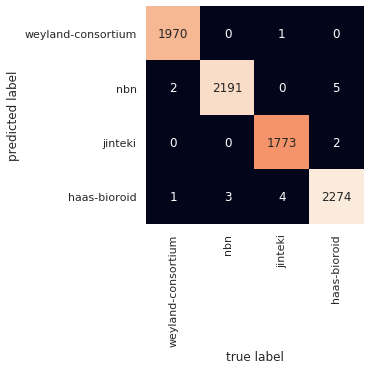

In [131]:
#First we try a naive_bayes model on both datasets to get a baseline
X = corp_X
y = corp_y

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X,y)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, train_size=0.5,test_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
print(accuracy_score(y2, y2_model))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
print(scores.mean())

#A list of the factions so we can label the confusoin matrix
faction_list = y.unique()

from sklearn.metrics import confusion_matrix
#make a confusion matrix to see mislabelings
mat = confusion_matrix(y2, y2_model)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faction_list, yticklabels=faction_list)
plt.xlabel('true label')
plt.ylabel('predicted label');

Text(0, 0.5, 'component 2')

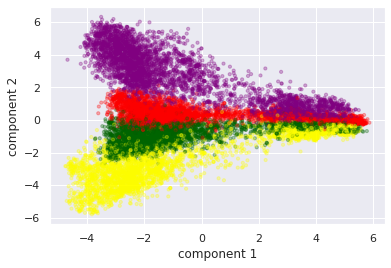

In [133]:
#now lets see if we can get a visulazition by reducing the data to 2 dimensions with a pca
X = corp_X
y = corp_y

from sklearn.decomposition import PCA
pca = PCA(2)
projected = pca.fit_transform(X)

#color the varius factions themeatically
colors =[]
for ident in y:
    if ident == 'weyland-consortium':
        color = 'darkgreen'
        
    if ident == 'nbn':
        color = 'yellow'
        
    if ident == 'jinteki':
        color = 'red'
        
    if ident == 'haas-bioroid':
        color = 'purple'
        
    if ident == 'shaper':
        color = 'lightgreen'
        
    if ident == 'criminal':
        color = 'blue'
        
    if ident == 'anarch':
        color = 'orange'
        
    if ident == 'apex':
        color = 'black'
        
    if ident == 'sunny-lebeau':
        color = 'magenta'
        
    if ident == 'adam':
        color = 'gold'
    colors.append(color)

#plot of all decks in 2-D    
plt.scatter(projected[:, 0], projected[:, 1],s=10,c=colors,alpha=0.3)
plt.xlabel('component 1')
plt.ylabel('component 2')

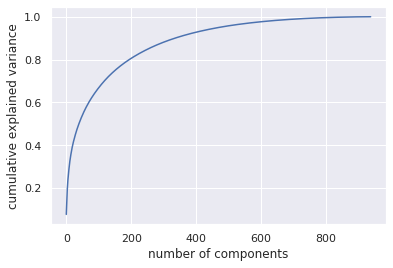

In [134]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
#Now let's try to get a guassian mixture model
#hopefully we will be able to make decks after this...

X = corp_X
y = corp_y

#We might need to reduce dimension...
from sklearn.decomposition import PCA
print(X.shape)
pca = PCA(0.9, whiten=True)
reduced_X = pca.fit_transform(X)
print(reduced_X.shape)

(16451, 939)
(16451, 336)


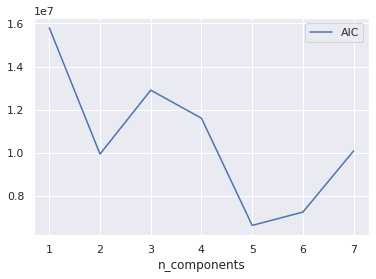

In [159]:
#Find the correct number of components for GMM
from sklearn.mixture import GaussianMixture
n_components = np.arange(1, 8)
models = [GaussianMixture(n, covariance_type='full').fit(reduced_X)
          for n in n_components]

plt.plot(n_components, [m.aic(reduced_X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [160]:
#from the above recomendation we pick 5 components
gmm = GaussianMixture(n_components=5, covariance_type='full').fit(reduced_X)

In [270]:
#make new decks
data_new = gmm.sample()
pca.inverse_transform(data_new[0])[0]
deck_quant = [0 if i <0 else i for i in pca.inverse_transform(data_new[0])[0].round()]
deck_new = pd.Series(deck_quant,corp_decks.iloc[:,:-4].keys())
print(deck_new.sum())
display_deck(deck_new)

60.0


['1.0x Nisei MK II',
 '1.0x Chum',
 '1.0x Neural Katana',
 '1.0x Hostile Takeover',
 '1.0x Beanstalk Royalties',
 '1.0x Ice Wall',
 '1.0x PAD Campaign',
 '2.0x Enigma',
 '1.0x Braintrust',
 '1.0x Cerebral Overwriter',
 '1.0x Quandary',
 '2.0x Medical Breakthrough',
 '1.0x Shi.Kyū',
 '1.0x Komainu',
 '1.0x Pup',
 '1.0x Guard',
 '2.0x Fast Track',
 '1.0x Paywall Implementation',
 '1.0x Hostile Infrastructure',
 '2.0x Turtlebacks',
 '1.0x Cyberdex Virus Suite',
 '1.0x Spiderweb',
 '1.0x News Team',
 '1.0x Global Food Initiative',
 '1.0x Vanilla',
 '1.0x Kakugo',
 '1.0x Oberth Protocol',
 '1.0x Audacity',
 '2.0x Obokata Protocol',
 '1.0x Shipment from Tennin',
 '1.0x Standoff',
 '2.0x Breached Dome',
 '1.0x Illegal Arms Factory',
 '1.0x Colossus',
 '1.0x Hortum',
 '1.0x Hostile Takeover',
 '1.0x Ice Wall',
 '1.0x Beanstalk Royalties',
 '1.0x Punitive Counterstrike',
 '1.0x Snare!',
 '2.0x Hedge Fund',
 '1.0x NGO Front',
 '1.0x Bio Vault',
 '1.0x Rashida Jaheem',
 '1.0x Too Big to Fail',
 '